## Environment

In [107]:
import numpy as np

In [108]:
class Environment_Multiple_Contexts():

  def __init__(self, n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost):
    self.n_arms = n_arms                                            # number of prices
    self.probabilities = probabilities                              # conversion rates for every price/arm
    self.bids = bids                                                # bids
    self.average_number_of_clicks = average_number_of_clicks        # curve of average number of clicks (y = f(bids))
    self.average_cum_daily_cost = average_cum_daily_cost            # curve of cumulative daily cost (y = g(bids))
    self.noise_clicks = noise_clicks                                # gaussian noise for the average number of clicks sampling
    self.noise_cost = noise_cost                                    # gaussian noise for the cumulative daily cost sampling

  def pull_features(self):
    x1 = np.random.binomial(1,1/3)
    x2 = np.random.binomial(1,1/2)
    if x1 == 1:
      i=0
    elif x2 == 1:
      i=1
    else:
      i=2
    return x1, x2, i

  # daily rewards
  def bidding_round(self, pulled_bid, i):
    clicks = int(np.random.normal(self.average_number_of_clicks[i](self.bids[pulled_bid]),self.noise_clicks[i]))        # number of people that click on the ad
    reward_click = clicks if clicks >= 0 else 0
    costs = np.random.normal(self.average_cum_daily_cost[i](self.bids[pulled_bid]),self.noise_cost[i])                  # cumulative daily cost
    reward_cost = costs if costs > 0 else 0
    return reward_click, reward_cost

  def pricing_round(self, pulled_price, i):
    reward_price = np.random.binomial(1,self.probabilities[i][pulled_price])                         # number of people that buy once they clicked
    return reward_price

## Pricing

In [109]:
class Learner:
  def __init__(self,n_arms):
    self.n_arms = n_arms
    self.t = 0                                              # current round value
    self.rewards_per_arm = x = [[] for i in range(n_arms)]  # value of collected rewards for each round and for each arm
    self.collected_rewards = np.array([])                   # values of collected rewards for each round

  # function that updates the observation's list once the reward is returned by the environment
  def update_observations(self, pulled_arm, reward):
    pulled_arm = int(pulled_arm)
    self.rewards_per_arm[pulled_arm].append(reward)
    self.collected_rewards = np.append(self.collected_rewards,reward)

In [110]:
class TS_Pricing_Learner(Learner): # Thompson-Sampling (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices):
    super().__init__(n_arms)                    # number of prices
    self.beta_parameters = np.ones((n_arms,2))  # parameters of beta distributions
    self.prices = prices                        # prices (array)

    #self.empirical_means = np.zeros(n_arms)

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    sampled = np.random.beta(self.beta_parameters[:,0],self.beta_parameters[:,1])*self.prices
    idx = np.argmax(sampled)
    #return idx, sampled[idx]
    return idx

  # update parameters each time a reward in {0,1} is observed
  def update(self,pulled_arm, reward):
    self.t += 1
    pulled_arm = int(pulled_arm)
    self.update_observations(pulled_arm,reward*self.prices[pulled_arm])
    self.beta_parameters[pulled_arm,0] = self.beta_parameters[pulled_arm,0] + reward
    self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1] + 1 - reward

    #self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(len(self.rewards_per_arm[pulled_arm]) - 1) + reward*self.prices[pulled_arm] ) / len(self.rewards_per_arm[pulled_arm])

  # REVIEW: reimplement better
  def initialize_learner(self, collected_features):
    for features in collected_features:
      self.update(features[0], features[1])



In [111]:
class UCB_Pricing_Learner(Learner): # UCB1 (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices):
    super().__init__(n_arms)                              # number of arms/prices
    self.empirical_means = np.zeros(n_arms)               # mean reward for each arm (conversion rate)
    self.confidence = np.zeros(n_arms)                    # confidence bound for each arm
    self.prices = prices                                  # prices (array)

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    upper_bound = self.empirical_means + self.confidence
    pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0])
    #return pulled_arm, upper_bound[pulled_arm]
    #return pulled_arm, self.empirical_means[pulled_arm]
    return pulled_arm

  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward*self.prices[pulled_arm])
    self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(len(self.rewards_per_arm[pulled_arm]) - 1) + reward*self.prices[pulled_arm] ) / len(self.rewards_per_arm[pulled_arm])
    self.confidence[pulled_arm] = self.prices[pulled_arm]*np.sqrt(2*np.log(self.t)/len(self.rewards_per_arm[pulled_arm]))

## Advertising

In [112]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [113]:
class GPTS_Learner(Learner):
  # constructor takes as input the number arms (bids), intializes to 0 their means and to an aye their standard deviation; we also need to store the arm that we pull at each round to fot the GPs
  def __init__(self, n_arms, arms, alpha_clicks, alpha_costs, normalize_y = False, step = 1, step_delay = 366, n_restarts_optimizer = 0, plot = False):
    super().__init__(n_arms)
    self.arms = arms
    self.means_clicks = np.ones(self.n_arms) * 1e3
    self.means_costs = np.ones(self.n_arms) * 1e3
    self.sigmas_clicks = np.ones(self.n_arms)
    self.sigmas_costs = np.ones(self.n_arms)
    self.pulled_arms = []
    self.collected_clicks = np.array([])
    self.collected_costs = np.array([])
    # we initialize the parameters of the kernel and the two GPs
    if normalize_y:
      kernel_clicks = C(2000.,(1000.,5000.)) * RBF(0.3,(0.01,0.6)) # for normalized
      kernel_costs = C(2000.,(1000.,5000.)) * RBF(0.3,(0.01,0.6)) # for normalized
    else:
      kernel_clicks = C(1,(1e3,1e4)) * RBF(1,(0.1,1))
      kernel_costs = C(1, (1e3,1e4)) * RBF(1,(0.1,1))
    self.gp_clicks = GaussianProcessRegressor(kernel = kernel_clicks, alpha = alpha_clicks**2, normalize_y = normalize_y, n_restarts_optimizer = n_restarts_optimizer)
    self.gp_costs = GaussianProcessRegressor(kernel = kernel_costs, alpha = alpha_costs**2, normalize_y = normalize_y, n_restarts_optimizer = n_restarts_optimizer)
    self.plot = plot
    self.step = step
    self.step_delay = step_delay

  # we also need to update the value of the least pulled arm (reward[0]: n_clicks, reward[1]: costs)
  def update_observations(self, arm_idx, reward):
    arm_idx = int(arm_idx)
    super().update_observations(arm_idx, reward)
    self.pulled_arms.append(self.arms[arm_idx])

  # update the GP estimations and consequently the means and sigmas of each arm
  def update_model(self):
    # trining inputs and targets
    if self.t < self.step_delay or not(self.t % self.step):
      x = np.atleast_2d(self.pulled_arms).T
      y_clicks = self.collected_clicks
      y_costs = self.collected_costs
      # fit the GP
      if len(y_clicks) > 1:
        self.gp_clicks.fit(x,y_clicks)
        self.gp_costs.fit(x,y_costs)
        # update values of means and sigmas with the new predictions
        self.means_clicks, self.sigmas_clicks = self.gp_clicks.predict(np.atleast_2d(self.arms).T, return_std = True)
        self.means_costs, self.sigmas_costs = self.gp_costs.predict(np.atleast_2d(self.arms).T, return_std = True)
        self.sigmas_clicks = np.maximum(self.sigmas_clicks, 1e-2)
        self.sigmas_costs = np.maximum(self.sigmas_costs, 1e-2)

      if self.plot:
        plt.figure()
        plt.title("Clicks:" + str(self.t))
        plt.plot(self.arms, clicks(self.arms), 'r:', label = r'$n(x)$')
        plt.plot(x.ravel(), y_clicks.ravel(), 'ro', label = u'Observed Clicks')
        plt.plot(self.arms, self.means_clicks, 'b-', label = u'Predicted Clicks')
        plt.fill(np.concatenate([self.arms,self.arms[::-1]]),
                np.concatenate([self.means_clicks - 1.96 * self.sigmas_clicks , (self.means_clicks + 1.96 * self.sigmas_clicks)[::-1]]),
                alpha = .5, fc = 'b', ec = 'None', label = '95% conf interval')
        plt.xlabel('$x')
        plt.ylabel('$n(x)$')
        plt.legend(loc = 'lower right')
        plt.show()

        plt.figure()
        plt.title("Costs:" + str(self.t))
        plt.plot(self.arms, costs(self.arms), 'r:', label = r'$c(x)$')
        plt.plot(x.ravel(), y_costs.ravel(), 'ro', label = u'Observed Costs')
        plt.plot(self.arms, self.means_costs, 'b-', label = u'Predicted Costs')
        plt.fill(np.concatenate([self.arms,self.arms[::-1]]),
                np.concatenate([self.means_costs - 1.96 * self.sigmas_costs , (self.means_costs + 1.96 * self.sigmas_costs)[::-1]]),
                alpha = .5, fc = 'b', ec = 'None', label = '95% conf interval')
        plt.xlabel('$x')
        plt.ylabel('$c(x)$')
        plt.legend(loc = 'lower right')
        plt.show()

  # functions that calls the functions implemented above (reward[0]: n_clicks, reward[1]: costs)
  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward)
    self.collected_clicks = np.append(self.collected_clicks,reward[0])
    self.collected_costs = np.append(self.collected_costs,reward[1])
    self.update_model()

  # function in which the learner chooses the arm to pull at each round
  def pull_arm(self):
    # returns index of the maximum value drawn from the arm normal distribution
    samples = np.random.normal(self.means_clicks - self.means_costs, np.sqrt(self.sigmas_clicks**2 + self.sigmas_costs**2))
    return np.argmax(samples)

  def initialize_learner(self, collected_features):
    for t in range(int(collected_features[-1,-1])):
      mask = (collected_features[:,-1] == t)
      masked_features = collected_features[mask,:]
      unique_bids = np.unique(masked_features[:,2])
      for bid in unique_bids:
        aux = masked_features[(masked_features[:,2]==bid),:]
        clicks = aux.shape[0]
        costs = np.sum(aux[:,3],axis=0)
        self.update_observations(bid,[clicks,costs])
        self.collected_clicks = np.append(self.collected_clicks,clicks)
        self.collected_costs = np.append(self.collected_costs,costs)
      self.t += 1
    self.update_model()

In [114]:
class GPUCB_Learner(GPTS_Learner):
  def __init__(self, n_arms, arms, alpha_clicks, alpha_costs, normalize_y = False, step = 1, step_delay = 366, n_restarts_optimizer = 0, plot = False):
    super().__init__(n_arms, arms, alpha_clicks, alpha_costs, normalize_y, step, step_delay, n_restarts_optimizer, plot)

  # returns index of the maximum UCB from the arm normal distribution (coefficient for CI of order 1-1/T: 3.0)
  def pull_arm(self):
    upper_bound = self.means_clicks - self.means_costs + 3.0*np.sqrt(self.sigmas_clicks**2 + self.sigmas_costs**2)
    pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0])
    return pulled_arm

## Simulation

In [115]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [116]:
# generic
T = 365                                # horizon of experiment
n_experiments = 10                    # since the reward functions are stochastic, to better visualize the results and remove the noise we do multiple experiments

In [117]:
# pricing
n_prices = 5
prices = [5,6,7,8,9]
p = np.array([[0.15,0.1,0.1,0.35,0.1],
              [0.2,0.15,0.05,0.4,0.1],
              [0.25,0.15,0.1,0.1,0.2]])             # bernoulli distributions for the reward functions
opt_rate = [p[0][np.argmax(p[0]*prices)],
            p[1][np.argmax(p[1]*prices)],
            p[2][np.argmax(p[2]*prices)]]                 # optimal arm

for i in range(0,3):
    print("Pricing (optimal price) context ", str(i))
    print("idx: " + str(np.argmax(p[i]*prices)) + "  price: " + str(prices[np.argmax(p[i]*prices)]) + "  rate: " + str(opt_rate[i]) + "  price*rate: " + str(opt_rate[i]*prices[np.argmax(p[i]*prices)]))

Pricing (optimal price) context  0
idx: 3  price: 8  rate: 0.35  price*rate: 2.8
Pricing (optimal price) context  1
idx: 3  price: 8  rate: 0.4  price*rate: 3.2
Pricing (optimal price) context  2
idx: 4  price: 9  rate: 0.2  price*rate: 1.8


Advertising (optimal bid):
idx: 65  bid: 0.6565656565656566  clicks-costs: 13.794848078095768
Advertising (optimal bid):
idx: 60  bid: 0.6060606060606061  clicks-costs: 9.48939393061842
Advertising (optimal bid):
idx: 55  bid: 0.5555555555555556  clicks-costs: 34.04899438162843


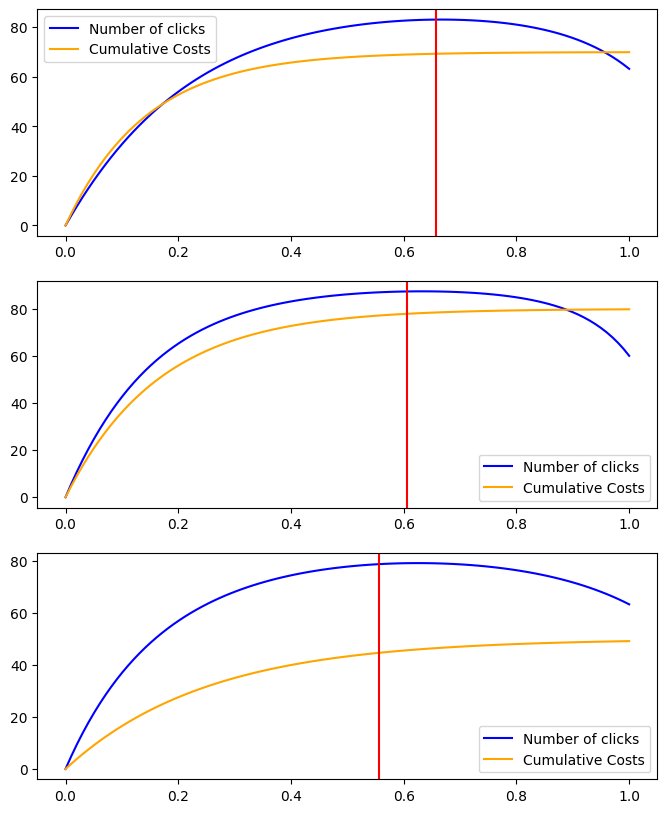

In [118]:
# advertising
n_bids = 100
min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_bids)
sigma_clicks = [3, 2.5, 3]
sigma_costs = [3, 2.5, 3]

params_clicks = [[100, 4, 3, 3],
                 [95,  6, 5, 3],
                 [100, 5, 4, 2]]
params_costs = [[70, 7],
                [80, 6],
                [50, 4]]
def clicks(x, params=[100, 4, 3, 3]):
  return params[0] * (1.0 - np.exp(-params[1]*x+params[2]*x**params[3]))

def costs(x, params=[70, 7]):
  return params[0] * (1.0 - np.exp(-params[1]*x))


opt_bid = np.zeros(3)
for i in range(0,3):
    opt_bid[i] = bids[np.argmax(opt_rate[i]*prices[np.argmax(p[i]*prices)]*clicks(bids, params_clicks[i])-costs(bids, params_costs[i]))]

fig, ax = plt.subplots(3, figsize=(8,10))
for i in range(0, 3):
    ax[i].plot(bids,clicks(bids, params_clicks[i]),'blue',bids, costs(bids, params_costs[i]),'orange')
    ax[i].legend(["Number of clicks", "Cumulative Costs"])
    ax[i].axvline(opt_bid[i],c='red')
    print("Advertising (optimal bid):")
    print("idx: " + str(np.argmax(opt_rate[i]*prices[np.argmax(p[i]*prices)]*clicks(bids, params_clicks[i])-costs(bids, params_costs[i]))) + "  bid: " + str(opt_bid[i]) + "  clicks-costs: " + str(clicks(opt_bid[i], params_clicks[i])-costs(opt_bid[i], params_costs[i])))

In [119]:
# Function wrapper to be able to pass to environment
def clicks1(x):
    return clicks(x, params_clicks[0])
def clicks2(x):
    return clicks(x, params_clicks[1])
def clicks3(x):
    return clicks(x, params_clicks[2])

In [120]:
# Function wrapper to be able to pass to environment
def costs1(x):
    return costs(x, params_costs[0])
def costs2(x):
    return costs(x, params_costs[1])
def costs3(x):
    return costs(x, params_costs[2])

In [121]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [241]:
def context_generation(collected_features, prices, features_to_check=[0,1], time=14): # INPUT: [x1, x2, pulled_price, reward_price] per row
    delta = 1/time

    # Calculate best expected reward for actual context without separation of features (context 0)
    er_arms_0 = [np.mean(collected_features[(collected_features[:,2]==arm)], axis=1)[3] * prices[arm] for arm in range(5)]
    length_er_arms_0 = [len(collected_features[(collected_features[:,2]==arm)]) for arm in range(5)]
    best_er_price_index_0 = np.argmax(er_arms_0)
    lb_best_er_arms_0 = max(er_arms_0) - prices[best_er_price_index_0]*np.sqrt(-np.log(delta)/(2*length_er_arms_0[best_er_price_index_0]))

    # for every feature
    splits = []

    #print(features_to_check)
    for i in features_to_check:
        # Estimate probabilities for the feature

        prob_0 = sum(collected_features[:,i]==0) / len(collected_features)
        prob_1 = 1 - prob_0

        # Calculate best expected rewards for contexts obtained by separating features (context1, context2)

        er_arms_1 = [np.mean(collected_features[(collected_features[:,i]==0) * (collected_features[:,2]==arm)], axis=1)[3] * prices[arm] for arm in range(5)]
        er_arms_2 = [np.mean(collected_features[(collected_features[:,i]==1) * (collected_features[:,2]==arm)], axis=1)[3] * prices[arm] for arm in range(5)]

        length_er_arms_1 = [len(collected_features[(collected_features[:,i]==0) * (collected_features[:,2]==arm)]) for arm in range(5)]
        length_er_arms_2 = [len(collected_features[(collected_features[:,i]==1) * (collected_features[:,2]==arm)]) for arm in range(5)]

        best_er_price_index_1 = np.argmax(er_arms_1)
        best_er_price_index_2 = np.argmax(er_arms_2)

        # Calculate lower bound on best expect. rewards and probs

        lb_prob_0 = prob_0 - np.sqrt(-np.log(delta)/(2*sum(collected_features[:,i]==0)))
        lb_prob_1 = prob_1 - np.sqrt(-np.log(delta)/(2*sum(collected_features[:,i]==1)))

        lb_best_er_arms_1 = max(er_arms_1) - prices[best_er_price_index_1]*np.sqrt(-np.log(delta)/(2*length_er_arms_1[best_er_price_index_1]))
        lb_best_er_arms_2 = max(er_arms_2) - prices[best_er_price_index_2]*np.sqrt(-np.log(delta)/(2*length_er_arms_2[best_er_price_index_2]))

        splits.append(lb_best_er_arms_1*lb_prob_0 + lb_best_er_arms_2*lb_prob_1)

    #print(splits, lb_best_er_arms_0)

    # Select feature with max. value if larger than non-split case
    best_feature = np.argmax(splits)
    worse_feature = np.argmin(splits)
    if splits[best_feature] >= lb_best_er_arms_0:
        if len(features_to_check)-1 == 0: # If no other features to split
            return True, [features_to_check[best_feature]]
        # Check separation with the other feature within the actual separtion (for values = 0 and = 1)
        check_sub0, _ = context_generation(collected_features[collected_features[:,best_feature]==0], prices, features_to_check=[worse_feature])
        check_sub1, _ = context_generation(collected_features[collected_features[:,best_feature]==1], prices, features_to_check=[worse_feature])
        return True, [features_to_check[best_feature], features_to_check[worse_feature] if check_sub0 else None, features_to_check[worse_feature] if check_sub1 else None]

    return False, []


In [245]:
# Function testing
aux = []

for i in range(1000):
    x1 = 1 if np.random.binomial(1, 1/3) > 0.5 else 0
    x2 = 1 if np.random.binomial(1, 1/4) > 0.5 else 0
    #price_buy = max(0, np.random.normal(0,10))
    pulled_price = np.random.choice([0,1,2,3,4],p=p[0]/sum(p[0]))
    aux.append([x1,x2,pulled_price, np.random.binomial(1, 0)]) if x1 == 0 else aux.append([x1,x2,pulled_price, np.random.binomial(1, 1.)])

aux=np.array(aux)


context_generation(aux, prices, time=10000)

(False, [])

In [124]:
def create_learners(n_contexts, price, sigma_clicks, sigma_costs):
  pricing_learners_gpts = [TS_Pricing_Learner(n_arms = n_prices, prices = price) for c in range(n_contexts)]
  pricing_learners_gpucb =[TS_Pricing_Learner(n_arms = n_prices, prices = price) for c in range(n_contexts)]
  gpts_learners = [GPTS_Learner(n_arms = n_bids, arms = bids, alpha_clicks = sigma_clicks, alpha_costs = sigma_costs,
                              step = 1, normalize_y = False,plot = False, step_delay = 0) for c in range(n_contexts)]
  gpucb_learners = [GPUCB_Learner(n_arms = n_bids, arms = bids, alpha_clicks = sigma_clicks, alpha_costs = sigma_costs,
                                step = 1, normalize_y = False, step_delay = 0) for c in range(n_contexts)]

  gpts_daily_pricing_rewards = [np.array([]) for c in range(n_contexts)]
  gpucb_daily_pricing_rewards = [np.array([]) for c in range(n_contexts)]
  return pricing_learners_gpts, pricing_learners_gpucb, gpts_learners, gpucb_learners, gpts_daily_pricing_rewards, gpucb_daily_pricing_rewards


def click_constant_from_context(x1, x2):
  if x1 == 0:
    if x2 == 1:
      return [0,1,0]
    elif x2 == 0:
      return [0,0,1]
    elif x2 == 2:
      return [0,1,1]
  elif x1 == 1:
    if x2 == 1 or x2 == 0:
      return [1/2,0,0]
    elif x2 == 2:
      return [1,0,0]
  elif x1 == 2:
    if x2 == 1:
      return [1/2,1,0]
    elif x2 == 0:
      return [1/2,0,1]
    elif x2 == 2:
      return [1,1,1]

def save_results(x, T):
  np.savetxt("gpts_rewards_per_experiment"+str(T)+".csv", x, delimiter=",")

def load_results(fname):
  return np.loadtxt(fname, delimiter=",")

In [125]:
# PSEUDO-CODE
# 4.2:
  # run basic algorithm for 2 weeks (Aggregate model, 1 context), for every person (n total) observe also x1,x2
    # depending on x1 and x2 we use the corresponding environment variables: click and cost fct and sigmas, price probs.
    # use same prices for all classes

  # after 2 weeks, run context-generator algorithm (n tuples: [x1,x2,buy*price]) <=> classification algorithm that maps (x1,x2)->(a,b,c,... M classes, since we don't know the actual ones)
    # For x1 -> check split condition (using lower bound on the expected rewards)
    # For x2 -> check split condition (using lower bound on the expected rewards)
    # return current best context strategy

  # for each day 14:365 run Dissagregate model:
    # We create M bidding learners and M pricing learners
    # pull M bids -> mapped into 3 bids for the observation purposes
    # observe a certain amount of clicks (clicks1 [1,.], clicks2 [0,1], clicks3 [0,0]) -> mapped into clicks1, ..., clicksM by the context classification algorithm
      # for every person (n total) observe x1 and x2:
        # [1,1]->1  [0,1]->2 [1,0]->1, [0,0]->3 => clicks[1,1] = 1/2*clicks1, clicks[1,0] = 1/2*clicks1
        # [1,:]->1 [0,:]->2,3 => clicks[0,:] = clicks2 + clicks3
    # observe a certain amount of costs (costs1 [1,.], costs2 [0,1], costs3 [0,0]) -> mapped into costs1, ..., costsM by the context classification algorithm
      # same as clicks
    # update the M bidding_learners

    # for each class/context (1,...,M):
      # for each click:
        # pull a price
        # observe acquisition or not
        # update correspondin pricing_learner

    # after 2 weeks, update context-generator algorithm

  # reward: sum(rate[i]*price[i]*clicks[i] - costs[i])


In [232]:
# experiments
save_results_opt = False

temp_n_contexts = [1]

n_experiments = 10
T=30

rewards_for_experiments = []


for e in tqdm(range(0,n_experiments)):  # cycle on experiments
  env = Environment_Multiple_Contexts(n_arms = n_prices,
                                        probabilities = p,
                                        bids = bids,
                                        average_number_of_clicks = [clicks1, clicks2, clicks3],
                                        average_cum_daily_cost = [costs1, costs2, costs3],
                                        noise_clicks = sigma_clicks,
                                        noise_cost = sigma_costs)

  n_contexts = 1
  k = click_constant_from_context(x1=2, x2=2) # Generic context, no specific values for any of the two params

  collected_features = []
  # Create num of learners based on num of contexts
  pricing_learners_gpts, _, gpts_learners, __, gpts_daily_pricing_rewards, ___ = create_learners(n_contexts, prices,sigma_clicks[0], sigma_costs[0])

  collected_costs = np.array([])

  gpts_rewards_per_experiment = np.array([])

  for t in range(0, 14):# First two weeks with one context
    for j in range(n_contexts):
        pulled_bid_ts = gpts_learners[j].pull_arm()  # pull bid for each context
        # For each environment calculate num of clicks and cost
        reward_click_ts = 0
        reward_cost_ts = 0
        pulled_reward_price_arr = []
        for env_idx in range(3): # Loop over all possible environments and then check if we want to use it in the current context or not
          if k[env_idx] == 0:
            continue
          reward_click_ts_, reward_cost_ts_ = env.bidding_round(pulled_bid_ts, env_idx)
          reward_click_ts += k[env_idx]*reward_click_ts_
          reward_cost_ts += k[env_idx]*reward_cost_ts_

          for click_idx in range(reward_click_ts_):
            pulled_price = pricing_learners_gpts[j].pull_arm()

            reward_price = env.pricing_round(pulled_price, env_idx)
            # Set x1 and x2 to the current context's feature space. REVIEW: could be implemented better probably
            if env_idx==0:
              if click_idx < reward_click_ts_/2: # FIXME: bernoulli instead of deterministic check
                x1 = 1
                x2 = 1
              else:
                x1 = 1
                x2 = 0
            elif env_idx==1:
              x1=0
              x2=1
            elif env_idx==2:
              x1=0
              x2=0
            # We do not directly update the pricing learner, but instead shuffle all info so no bias is introduced for each env
            pulled_reward_price_arr.append((pulled_price, reward_price, x1, x2, reward_click_ts_/reward_click_ts_))

        # After we shuffle we train
        np.random.shuffle(pulled_reward_price_arr)
        aux = 0
        for arr in pulled_reward_price_arr:
          pulled_price, reward_price, x1, x2, unitary_cost_ts = arr
          pricing_learners_gpts[j].update(pulled_price, reward_price)
          collected_features.append([x1, x2, pulled_price, reward_price, pulled_bid_ts, unitary_cost_ts, t])
          aux += reward_price*prices[pulled_price]
        gpts_learners[j].update(pulled_bid_ts, [reward_click_ts,reward_cost_ts]) # REVIEW: update of advert part should be here and not each time for each environment
        gpts_daily_pricing_rewards[j] = np.append(gpts_daily_pricing_rewards[j], aux)
        collected_costs = np.append(collected_costs, reward_cost_ts)

  #gpts_rewards_per_experiment = np.append(gpts_rewards_per_experiment, np.sum([gpts_daily_pricing_rewards[j] for j in range(n_contexts)], axis=0)-np.sum(collected_costs))


  # FIXME: do one loop instead of two
  for t in range(14, T):
    if t%14 == 0: # Each 14 days
      if save_results_opt:
        save_results(gpts_rewards_per_experiment, T=t)

      gpts_rewards_per_experiment = np.append(gpts_rewards_per_experiment, np.sum([gpts_daily_pricing_rewards[j] for j in range(n_contexts)], axis=0)-np.sum(collected_costs))

      # Context Generation algorithm
      collected_features=np.array(collected_features)
      split_condition, feature_tree = context_generation(collected_features[:,:4], prices=prices, time=collected_features.shape[0])

      if split_condition:
        first_feature = feature_tree[0]
        contexts = [[2, 2],[2, 2],[2, 2],[2, 2]]
        for i in range(2):
          contexts[2*i][first_feature] = i
          contexts[2*i+1][first_feature] = i
          if feature_tree[i+1] is not None:
            second_feature = int(not first_feature)
            contexts[2*i][second_feature] = 0
            contexts[2*i+1][second_feature] = 1
        contexts = list(set(map(tuple, contexts))) # Remove duplicates by creating set
        n_contexts = len(contexts)
      else: # One context, x1=. x2=.
        n_contexts = 1
        contexts=[(2,2)]

      temp_n_contexts.append(n_contexts)

      # Create num of learners based on num of contexts
      pricing_learners_gpts, _, gpts_learners, __, gpts_daily_pricing_rewards, ___ = create_learners(n_contexts, prices,sigma_clicks[0], sigma_costs[0])

      for j in range(n_contexts):
        x1,x2 = contexts[j]
        mask = np.ones(len(collected_features), dtype=bool)
        if x1 == 2 and x2!=2:
          mask = (collected_features[:,1]==x2)
        elif x2 == 2 and x1 !=2:
          mask = (collected_features[:,0]==x1)
        elif x1!=2 and x2 != 2:
          mask = (collected_features[:,0]==x1) and (collected_features[:,1]==x2)

        pricing_learners_gpts[j].initialize_learner(collected_features[mask,2:])
        gpts_learners[j].initialize_learner(collected_features[mask,2:])

      collected_costs = np.array([])

    for j in range(n_contexts):
        k = click_constant_from_context(x1=contexts[j][0], x2=contexts[j][1]) # Generic context, no specific values for any of the two params

        pulled_bid_ts = gpts_learners[j].pull_arm()  # pull bid for each context
        # For each environment calculate num of clicks and cost
        reward_click_ts = 0
        reward_cost_ts = 0
        pulled_reward_price_arr = []
        for env_idx in range(3): # Loop over all possible environments and then check if we want to use it in the current context or not
          if k[env_idx] == 0:
            continue
          reward_click_ts_, reward_cost_ts_ = env.bidding_round(pulled_bid_ts, env_idx)
          reward_click_ts += k[env_idx]*reward_click_ts_
          reward_cost_ts += k[env_idx]*reward_cost_ts_

          for click_idx in range(reward_click_ts_):
            pulled_price = pricing_learners_gpts[j].pull_arm()

            reward_price = env.pricing_round(pulled_price, env_idx)
            # Set x1 and x2 to the current context's feature space. REVIEW: could be implemented better probably
            if env_idx==0:
              if click_idx < reward_click_ts_/2:
                x1 = 1
                x2 = 1
              else:
                x1 = 1
                x2 = 0
            elif env_idx==1:
              x1=0
              x2=1
            elif env_idx==2:
              x1=0
              x2=0
            # We do not directly update the pricing learner, but instead shuffle all info so no bias is introduced for each env
            pulled_reward_price_arr.append((pulled_price, reward_price, x1, x2,reward_click_ts_/reward_click_ts_))

        # After we shuffle we train
        np.random.shuffle(pulled_reward_price_arr)
        aux = 0
        for arr in pulled_reward_price_arr:
          pulled_price, reward_price, x1, x2, unitary_cost_ts = arr
          pricing_learners_gpts[j].update(pulled_price, reward_price)
          collected_features = np.append(collected_features, np.array([x1, x2, pulled_price, reward_price, pulled_bid_ts, unitary_cost_ts, t]).reshape((1,collected_features.shape[1])), axis=0)
          aux += reward_price*prices[pulled_price]
        gpts_learners[j].update(pulled_bid_ts, [reward_click_ts,reward_cost_ts]) # REVIEW: update of advert part should be here and not each time for each environment
        gpts_daily_pricing_rewards[j] = np.append(gpts_daily_pricing_rewards[j], aux)
        collected_costs = np.append(collected_costs, reward_cost_ts)

  gpts_rewards_per_experiment = np.append(gpts_rewards_per_experiment, np.sum([gpts_daily_pricing_rewards[j] for j in range(n_contexts)], axis=0)-np.sum(collected_costs))

  rewards_for_experiments.append(gpts_rewards_per_experiment)

  0%|          | 0/10 [00:00<?, ?it/s]

[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 ...
 [1. 1. 3. 0.]
 [1. 0. 3. 0.]
 [0. 1. 3. 1.]]
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 ...
 [1. 1. 3. 0.]
 [1. 0. 3. 1.]
 [0. 0. 3. 0.]]


 10%|█         | 1/10 [00:01<00:16,  1.80s/it]

[[0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 ...
 [0. 1. 3. 1.]
 [1. 1. 3. 1.]
 [1. 0. 3. 1.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 ...
 [0. 0. 3. 0.]
 [1. 0. 3. 1.]
 [1. 0. 3. 1.]]
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 1.]
 ...
 [0. 1. 3. 1.]
 [0. 1. 3. 1.]
 [1. 1. 3. 1.]]


 10%|█         | 1/10 [00:04<00:37,  4.19s/it]


KeyboardInterrupt: ignored

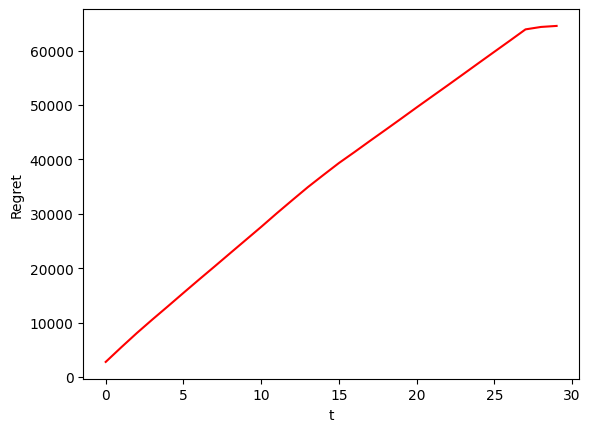

In [229]:
opt = np.sum([opt_rate[i]*prices[np.argmax(p[i]*prices)]*clicks(opt_bid[i], params_clicks[i]) - costs(opt_bid[i], params_costs[i]) for i in range(3)])


plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(opt - rewards_for_experiments, axis = 0)), 'r-')
# plt.plot(np.cumsum(np.mean(opt - np.sum(gpucb_rewards_per_experiment, axis=0), axis = 0)), 'b-')
#plt.legend(["GPTS","GPUCB"])
plt.show()